<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/Phone_CNN_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 경로 설정
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/UCI HAR Dataset'

def load_file(filepath):
    df = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return df.values

def load_group(filenames, prefix=''):
    loaded = []
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    return np.dstack(loaded)   # (samples, timesteps, features)

def load_dataset_group(group, prefix=''):
    filepath = prefix + '/' + group + '/Inertial Signals/'
    filenames = [
        f'total_acc_x_{group}.txt', f'total_acc_y_{group}.txt', f'total_acc_z_{group}.txt',
        f'body_acc_x_{group}.txt',  f'body_acc_y_{group}.txt',  f'body_acc_z_{group}.txt',
        f'body_gyro_x_{group}.txt', f'body_gyro_y_{group}.txt', f'body_gyro_z_{group}.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + '/' + group + f'/y_{group}.txt')
    return X, y

def load_dataset(prefix=BASE_PATH):
    trainX, trainy = load_dataset_group('train', prefix)
    testX,  testy  = load_dataset_group('test',  prefix)

    # 1~6 → 0~5
    trainy = trainy - 1
    testy  = testy - 1

    trainy_oh = to_categorical(trainy)
    testy_oh  = to_categorical(testy)

    print('trainX:', trainX.shape,
          'trainy:', trainy.shape,
          'testX:', testX.shape,
          'testy:', testy.shape)

    return trainX, trainy, trainy_oh, testX, testy, testy_oh


#. 데이터 불러오기
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-1322140836.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1322140836.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1322140836.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1322140836.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-13221

trainX: (7352, 128, 9) trainy: (7352, 1) testX: (2947, 128, 9) testy: (2947, 1)


/tmp/ipython-input-1322140836.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1322140836.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [40]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

# (N, T, F) → (N*T, F)로 펴서 스케일링
N_train, T, F = trainX.shape
N_test = testX.shape[0]

scaler = MinMaxScaler()

trainX_2d = trainX.reshape(-1, F)
testX_2d  = testX.reshape(-1, F)

scaler.fit(trainX_2d)
trainX_scaled = scaler.transform(trainX_2d).reshape(N_train, T, F)
testX_scaled  = scaler.transform(testX_2d).reshape(N_test, T, F)



In [41]:
# 2. train/val 분리
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    trainX_scaled, trainy_one_hot,
    test_size=0.2,
    random_state=42,
    stratify=trainy_one_hot
)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# 입력 차원
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

(5881, 128, 9) (1471, 128, 9) (5881, 6) (1471, 6)


In [42]:
# 3. CNN + GRU 모델
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dropout, Dense

model = Sequential()

# CNN 부분
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# GRU 부분
model.add(GRU(128, return_sequences=True))
model.add(GRU(64))
model.add(Dropout(0.3))

# Dense 분류기
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 124, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 62, 128)        │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,994 (519.51 KB)

 Trainable params: 132,994 (519.51 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# 4. 학습
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3882 - loss: 1.4102 - val_accuracy: 0.5493 - val_loss: 1.0192
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6423 - loss: 0.7980 - val_accuracy: 0.7947 - val_loss: 0.4315
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8096 - loss: 0.4341 - val_accuracy: 0.7770 - val_loss: 0.4246
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8562 - loss: 0.3408 - val_accuracy: 0.9191 - val_loss: 0.1984
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9006 - loss: 0.2491 - val_accuracy: 0.9055 - val_loss: 0.2258
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9017 - loss: 0.2441 - val_accuracy: 0.9143 - val_loss: 0.1840
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9215 - loss: 0.1962 - val_accuracy: 0.9239 - val_loss: 0.1641
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9203 - loss: 0.1931 - val_accu

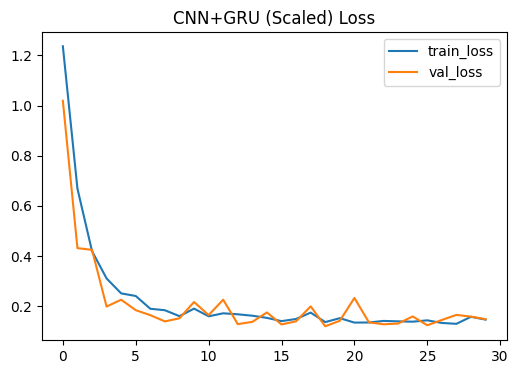

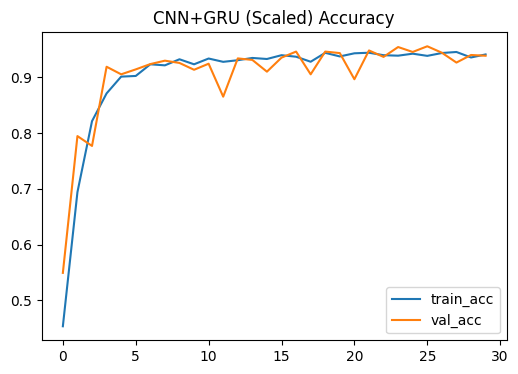

In [44]:
# 5. 학습 그래프
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('CNN+GRU (Scaled) Loss')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('CNN+GRU (Scaled) Accuracy')
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
 CNN+GRU (Scaled) Test Accuracy: 0.9263657957244655
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       496
           1       0.99      0.96      0.97       471
           2       0.97      0.99      0.98       420
           3       0.76      0.91      0.83       491
           4       0.90      0.74      0.81       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



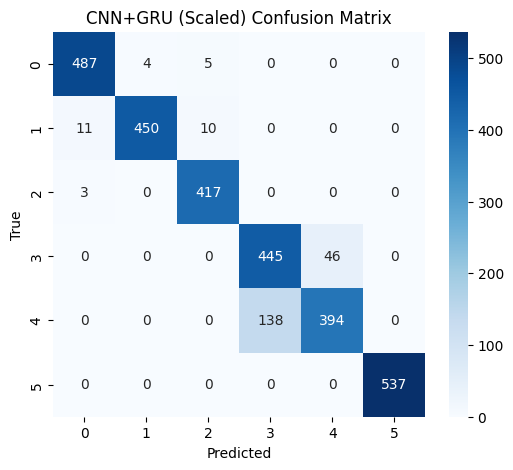

In [45]:
# 6. 테스트 평가
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_pred_prob = model.predict(testX_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = testy.ravel()

print(" CNN+GRU (Scaled) Test Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN+GRU (Scaled) Confusion Matrix")
plt.show()